## 0. Imports, Installs & Settings

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Preprocessing

In [5]:
# Create a DataFrame

IMAGE_PATH = "../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/"
MASK_PATH = "../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/"

In [6]:
num_classes = 23

In [7]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split(".")[0])
            
    return pd.DataFrame({"id": name}, index = np.arange(0, len(name)))

In [8]:
df = create_df()
print("Total images: ", len(df))

Total images:  400


In [9]:
# Split the Data
X_train, X_valtest = train_test_split(df["id"].values, test_size=0.12, random_state=1)
X_val, X_test = train_test_split(X_valtest, test_size=0.5, random_state=1)

In [10]:
# Sanity Check
print("Train Size: ", len(X_train))
print("Val Size: ", len(X_val))
print("Test Size: ", len(X_test))

Train Size:  352
Val Size:  24
Test Size:  24


In [ ]:
img = Image.open(IMAGE_PATH + df["id"][160] + ".jpg")
mask = Image.open(MASK_PATH + df["id"][160] + ".png")

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title("Image w/mask")
plt.show()

## 2. Create Model

In [ ]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + ".jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + ".png", cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug["image"])
            mask = aug["mask"]
            
        if self.transform is None:
            img = Image.fromarray(img)
            
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):
        
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view()(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches.contiguous().view(-1, 512, 512)
        
        return img_patches, mask_patches

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)   

In [ ]:
model = smp.Unet("mobilenet_v2", encoder_weights="imagenet", classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [ ]:
print(model)

## 3. Training

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3
epoch = 25
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

In [20]:
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.335 
Epoch:1/88.. Train Loss: 2.816.. Val Loss: 2.335.. Train mIoU:0.053.. Val mIoU: 0.083.. Train Acc:0.318.. Val Acc:0.528.. Time: 5.16m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 2.335 >> 2.012 
Epoch:2/88.. Train Loss: 2.310.. Val Loss: 2.012.. Train mIoU:0.088.. Val mIoU: 0.100.. Train Acc:0.532.. Val Acc:0.588.. Time: 4.74m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 2.012 >> 1.705 
Epoch:3/88.. Train Loss: 2.037.. Val Loss: 1.705.. Train mIoU:0.106.. Val mIoU: 0.117.. Train Acc:0.577.. Val Acc:0.630.. Time: 4.76m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 1.705 >> 1.459 
saving model...
Epoch:4/88.. Train Loss: 1.710.. Val Loss: 1.459.. Train mIoU:0.115.. Val mIoU: 0.127.. Train Acc:0.619.. Val Acc:0.647.. Time: 4.76m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 1.459 >> 1.221 
Epoch:5/88.. Train Loss: 1.464.. Val Loss: 1.221.. Train mIoU:0.128.. Val mIoU: 0.147.. Train Acc:0.643.. Val Acc:0.675.. Time: 4.68m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 1.221 >> 1.050 
Epoch:6/88.. Train Loss: 1.271.. Val Loss: 1.050.. Train mIoU:0.159.. Val mIoU: 0.204.. Train Acc:0.679.. Val Acc:0.736.. Time: 4.72m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:7/88.. Train Loss: 1.172.. Val Loss: 1.096.. Train mIoU:0.191.. Val mIoU: 0.195.. Train Acc:0.703.. Val Acc:0.719.. Time: 4.72m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 1.096 >> 0.887 
Epoch:8/88.. Train Loss: 1.105.. Val Loss: 0.887.. Train mIoU:0.210.. Val mIoU: 0.255.. Train Acc:0.714.. Val Acc:0.768.. Time: 4.70m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:9/88.. Train Loss: 1.017.. Val Loss: 0.905.. Train mIoU:0.224.. Val mIoU: 0.244.. Train Acc:0.733.. Val Acc:0.751.. Time: 4.68m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.905 >> 0.817 
Epoch:10/88.. Train Loss: 0.919.. Val Loss: 0.817.. Train mIoU:0.244.. Val mIoU: 0.274.. Train Acc:0.753.. Val Acc:0.777.. Time: 4.72m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.817 >> 0.810 
saving model...
Epoch:11/88.. Train Loss: 0.882.. Val Loss: 0.810.. Train mIoU:0.260.. Val mIoU: 0.265.. Train Acc:0.761.. Val Acc:0.766.. Time: 4.70m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:12/88.. Train Loss: 0.871.. Val Loss: 0.827.. Train mIoU:0.259.. Val mIoU: 0.262.. Train Acc:0.761.. Val Acc:0.769.. Time: 4.68m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.827 >> 0.798 
Epoch:13/88.. Train Loss: 0.885.. Val Loss: 0.798.. Train mIoU:0.261.. Val mIoU: 0.277.. Train Acc:0.755.. Val Acc:0.782.. Time: 4.70m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:14/88.. Train Loss: 0.804.. Val Loss: 0.909.. Train mIoU:0.278.. Val mIoU: 0.242.. Train Acc:0.777.. Val Acc:0.751.. Time: 4.71m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.909 >> 0.771 
Epoch:15/88.. Train Loss: 0.963.. Val Loss: 0.771.. Train mIoU:0.238.. Val mIoU: 0.279.. Train Acc:0.722.. Val Acc:0.759.. Time: 4.72m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.771 >> 0.756 
Epoch:16/88.. Train Loss: 0.775.. Val Loss: 0.756.. Train mIoU:0.288.. Val mIoU: 0.297.. Train Acc:0.779.. Val Acc:0.776.. Time: 4.68m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.756 >> 0.633 
Epoch:17/88.. Train Loss: 0.735.. Val Loss: 0.633.. Train mIoU:0.299.. Val mIoU: 0.332.. Train Acc:0.792.. Val Acc:0.814.. Time: 4.74m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:18/88.. Train Loss: 0.749.. Val Loss: 0.948.. Train mIoU:0.297.. Val mIoU: 0.250.. Train Acc:0.786.. Val Acc:0.742.. Time: 4.73m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.948 >> 0.660 
saving model...
Epoch:19/88.. Train Loss: 0.779.. Val Loss: 0.660.. Train mIoU:0.292.. Val mIoU: 0.332.. Train Acc:0.775.. Val Acc:0.801.. Time: 4.71m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:20/88.. Train Loss: 0.806.. Val Loss: 0.778.. Train mIoU:0.299.. Val mIoU: 0.291.. Train Acc:0.762.. Val Acc:0.755.. Time: 4.78m


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 99.53 m


In [21]:
torch.save(model, 'Unet-Mobilenet.pt')

In [22]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

## 4. Evaluation

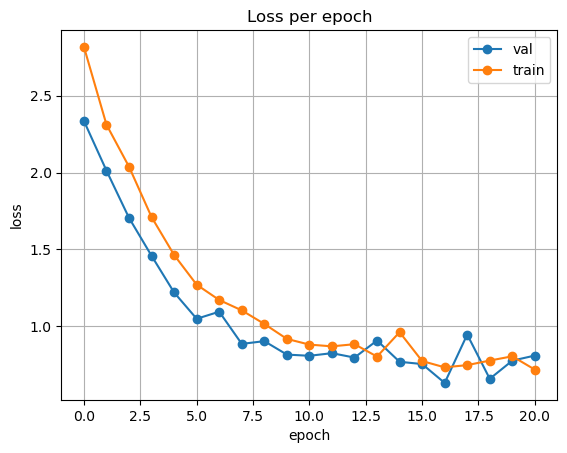

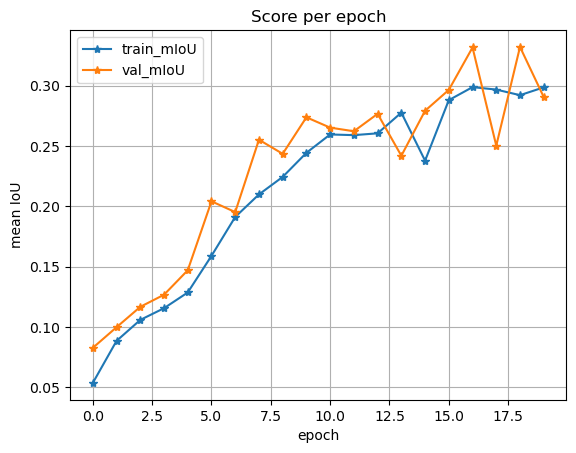

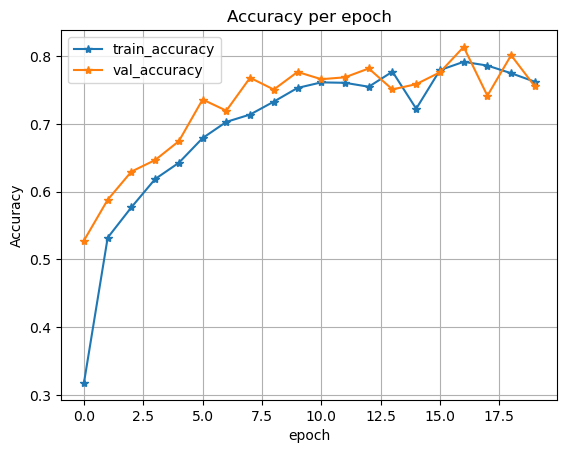

In [23]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [24]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [25]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [26]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [27]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [28]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [29]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/24 [00:00<?, ?it/s]

In [30]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [31]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/24 [00:00<?, ?it/s]

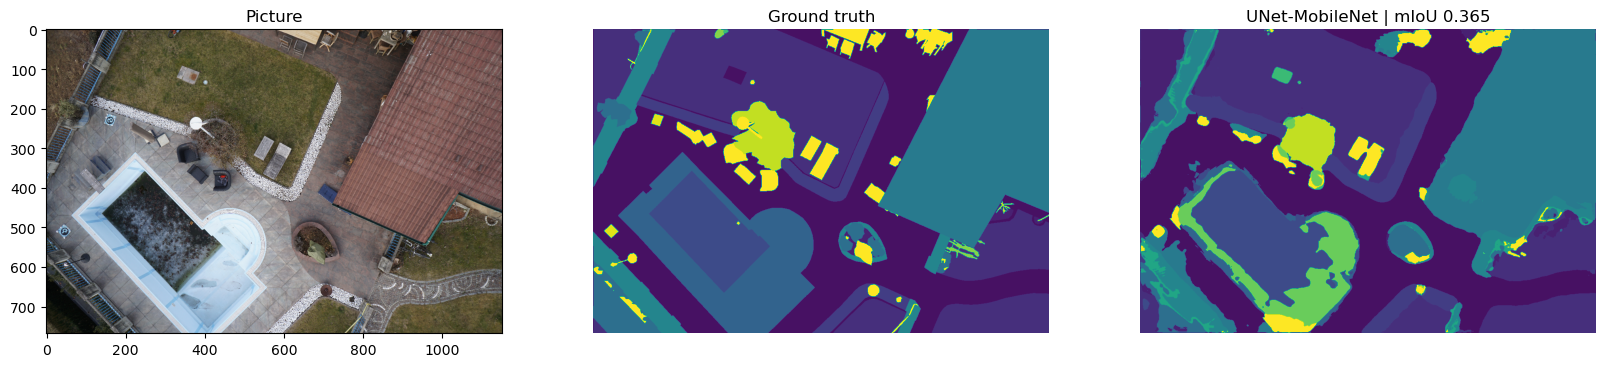

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [34]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.37724203280436513


In [35]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.8063383691104842
